### Dynamic Mean–Variance Portfolio Optimization via Discrete-Time LQR

- Research Goal :
    - Develop and analyze a **dynamic mean–variance portfolio optimization model** using the **Linear Quadratic Regulator (LQR)** and **Dynamic Programming (DP)** framework.  
    - Apply the model to a **multi-asset crypto portfolio** consisting of BTC, ETH, BNB, ADA, and XRP.  
    - Formulate the problem as a **discrete-time stochastic control system** that optimally balances expected return and portfolio variance over time.  
    - Compare **dynamic allocations** against static mean–variance benchmarks under realistic transaction costs and price slippage.

- Model Assumptions :
    - Time is discrete: $( t = 0, 1, 2, ..., T )$ with daily intervals.  
    - Asset prices follow stochastic processes with **Gaussian returns**:  
    $( r_t \sim \mathcal{N}(\mu_t, \Sigma_t) ). $ 
    - Covariance matrix $( \Sigma_t )$ is estimated from historical daily data (rolling window).  
    - No leverage or short selling: $( a_t \ge 0, \sum_i a_t^{(i)} = 1 ). $ 
    - Wealth dynamics are linear:

  $[
  X_{t+1} = (1 + r_f) X_t + X_t\, a_t^T (r_t - r_f \mathbf{1}) - c_t
  ]$
      where:
    - $( X_t )$ : portfolio wealth  
    - $( a_t )$ : allocation vector  
    - $( r_f )$ : risk-free rate (≈ 0 for crypto)  
    - $( c_t )$ : proportional transaction cost term

    - **Transaction cost and slippage model:**
    
  $[
  c_t = 0.0005 |a_t - a_{t-1}| + 0.0001 |a_t|
  ]$
  representing 0.05% trading cost and 0.01% slippage per transaction.

- Investor seeks to **minimize risk-adjusted variance** while achieving target terminal wealth $( X^* )$.

### Load Data :

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
csv_file = "crypto_close_prices_2022-01-01_to_2025-09-28.csv"
df = pd.read_csv(csv_file)

# Print the first 5 rows of the DataFrame
df

,Time,BTC,ETH,BNB,ADA,XRP
0,2022-01-01,47704.35,3763.06,527.34,1.3781,0.8507
1,2022-01-02,47280.00,3826.21,530.91,1.3769,0.8583
2,2022-01-03,46445.81,3764.07,512.24,1.3196,0.8324
3,2022-01-04,45833.42,3785.60,506.88,1.3093,0.8228
4,2022-01-05,43421.69,3537.71,473.95,1.2297,0.7718
...,...,...,...,...,...,...
1362,2025-09-24,113254.00,4150.51,1018.81,0.8124,2.9246
1363,2025-09-25,108934.50,3873.10,946.49,0.7633,2.7420
1364,2025-09-26,109588.50,4030.17,961.28,0.7915,2.7823
1365,2025-09-27,109577.30,4017.01,968.71,0.7807,2.8032


- Under the assumption of small daily returns, we approximate the exponential compounding effect by a first-order linearization of log returns. This yields a discrete linear wealth evolution model consistent with the LQR framework.
- Log return definition:

- $ r_t^{\text{log}} = \ln\left(\frac{P_t}{P_{t-1}}\right) $

In [3]:
# Set 'Time' as DateTime index
df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index('Time')

# Compute log returns
log_returns = np.log(df / df.shift(1)).dropna()
log_returns

,BTC,ETH,BNB,ADA,XRP
Time,,,,,
2022-01-02,-0.008935,0.016642,0.006747,-0.000871,0.008894
2022-01-03,-0.017801,-0.016374,-0.035799,-0.042506,-0.030641
2022-01-04,-0.013273,0.005704,-0.010519,-0.007836,-0.011600
2022-01-05,-0.054054,-0.067725,-0.067172,-0.062722,-0.063988
2022-01-06,-0.007900,-0.038352,-0.003149,0.039152,0.008900
...,...,...,...,...,...
2025-09-24,0.011608,-0.002825,0.001906,0.008405,0.035216
2025-09-25,-0.038886,-0.069176,-0.073630,-0.062342,-0.064470
2025-09-26,0.005986,0.039753,0.015505,0.036279,0.014590


In [4]:
log_returns.describe()

,BTC,ETH,BNB,ADA,XRP
count,1366.000000,1366.000000,1366.000000,1366.000000,1366.000000
mean,0.000626,0.000070,0.000463,-0.000391,0.000889
std,0.027310,0.036660,0.030092,0.045853,0.043636
min,-0.167335,-0.191068,-0.204358,-0.279716,-0.208480
25%,-0.011358,-0.016999,-0.012796,-0.023464,-0.018377
50%,-0.000003,0.000134,0.000878,-0.000586,0.000550
75%,0.012981,0.017172,0.014526,0.020874,0.017699
max,0.135881,0.198021,0.160055,0.542582,0.549458


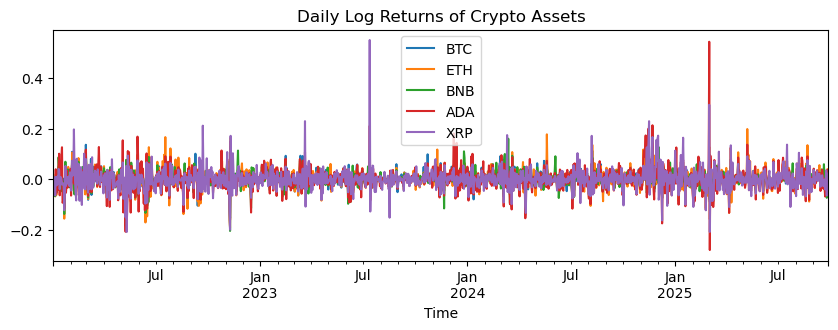

In [5]:
log_returns.plot(title="Daily Log Returns of Crypto Assets", figsize=(10,3))
plt.show()

In [15]:
# Extract time length and dimension
T = len(log_returns)
n_assets = log_returns.shape[1]
print(f"Number of periods T = {T}, number of assets n = {n_assets}")

Number of periods T = 1366, number of assets n = 5


### Static Markowitz–Lagrange optimization 

#### shrinkCov(X, shrink=0.05) :
- Estimate a stable covariance matrix for portfolio optimization.
- When returns $X \in \mathbb{R}^{T\times n}$ are noisy (few time samples, many assets), the raw sample covariance can be unstable or singular.
- To fix that, shrinkage blends $S$ with an identity matrix scaled by the average variance:

    - $\Sigma_{\text{shrunk}} = (1-\gamma)S + \gamma \bar{\sigma}^2 I$
    - where $\bar{\sigma}^2 = \frac{1}{n}\operatorname{tr}(S)$, and $\gamma \in [0,1]$ is your shrinkage intensity (here, 0.05).

In [13]:
def shrink_cov(X, shrink=0.05):
    """X: (T x n) returns. Simple diagonal shrinkage."""
    S = np.cov(X.T, bias=False)
    avg_var = np.trace(S)/S.shape[0]
    return (1-shrink)*S + shrink*avg_var*np.eye(S.shape[0])

#### project_to_simplex($v$) :
- Purpose: ensures portfolio is long-only and fully invested ($sum=1$).
- Project any vector $v$ into the probability simplex: 
$\Delta = \{w \in \mathbb{R}^n : w_i \ge 0,\ \sum_i w_i = 1\}.$

- Mathematical problem:  
$\min_{w\in \Delta} \|w - v\|_2^2$

    - The closed-form solution: $w_i = \max(v_i - \theta, 0)$, where $\theta$ is chosen so that $\sum_i w_i = 1$.


In [15]:
def project_to_simplex(v):
    """Euclidean projection onto {w >= 0, 1'w = 1}."""
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u*np.arange(1, len(v)+1) > (cssv - 1))[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1.0)
    return np.maximum(v - theta, 0.0)

#### Estimate_mu_Sigma(R_log, convert_to_simple=False)
- Estimate the expected return vector and covariance matrix of asset returns.
- If $R_{\log}$ is our matrix of log returns,
$\mu_{\log} = \frac{1}{T}\sum_{t=1}^T r_t^{(\log)}, \quad \Sigma_{\log} = \operatorname{Cov}(R_{\log})$.
- If we set convert_to_simple=True, it converts log means to simple means via the lognormal approximation:
$\mu_i^{(simple)} \approx e^{\mu_i^{(\log)} + 0.5\sigma_i^2} - 1.$
- This uses the expectation of a lognormal random variable:
$E[e^{r^{(\log)}}] = e^{\mu + \frac{1}{2}\sigma^2}.$

In [16]:
def estimate_mu_Sigma(R_log: pd.DataFrame, convert_to_simple=False):
    """R_log: T x n log-returns DataFrame."""
    mu_log = R_log.mean().values           # (n,)
    Sigma_log = R_log.cov().values         # (n,n)
    if not convert_to_simple:
        return mu_log, Sigma_log
    # Approx convert daily log-mean->simple mean; keep Sigma from logs
    var_log = np.diag(Sigma_log)
    mu_simple = np.exp(mu_log + 0.5*var_log) - 1.0
    return mu_simple, Sigma_log

#### Markowitz_risk_aversion(mu, Sigma, lam=10.0)
- Solve the mean–variance optimization problem with risk aversion $λ$.
- $\max_w \quad \mu^\top w - \frac{\lambda}{2} w^\top \Sigma w$  subject to $1^\top w = 1.$
- Lagrangian:

    $ \mathcal{L}(w, \nu) = \mu^\top w - \frac{\lambda}{2}w^\top \Sigma w - \nu(1^\top w - 1) $
    - First-order condition (FOC):
    $\nabla_w \mathcal{L} = 0 \Rightarrow \mu - \lambda \Sigma w - \nu 1 = 0, \Rightarrow \Sigma w = \frac{1}{\lambda}(\mu - \nu 1), \Rightarrow w = \frac{1}{\lambda} \Sigma^{-1}(\mu - \nu 1)$
    - Use the constraint $1^\top w = 1$ : Let $a = 1^\top \Sigma^{-1}\mu, \quad b = 1^\top \Sigma^{-1}1$.
    - Then $1 = \frac{1}{\lambda}(a - \nu b) \Rightarrow \nu = \frac{a - \lambda}{b}.$

- Final optimal weight:

    $\boxed{w^* = \frac{1}{\lambda}\Sigma^{-1}\left(\mu - \frac{a-\lambda}{b}1\right)}$

- We are trading off between expected return $(\mu)$ and risk $(w^\top \Sigma w)$ with intensity $1/\lambda.$
- Small $λ$ : risk-tolerant --> high-risk --> high-return portfolio.
- Large $λ$ : conservative --> low-risk --> diversified portfolio.


In [17]:
def markowitz_risk_aversion(mu, Sigma, lam=10.0):
    """max mu'w - (lam/2) w'Sigma w, s.t. 1'w=1 (Lagrange-constraint)."""
    invS = np.linalg.pinv(Sigma)
    ones = np.ones_like(mu)
    a = ones @ invS @ mu
    b = ones @ invS @ ones
    nu = (a - lam) / b
    w = (1.0/lam) * (invS @ (mu - nu*ones))
    return w / w.sum()  # numeric tidy -> sum=1

#### Markowitz_target_return(mu, Sigma, rho) :
- Solve for the portfolio that minimizes variance given: $1^\top w = 1,\quad \mu^\top w = \rho$.
- Lagrangian:

    $\mathcal{L}(w,\alpha,\beta) = w^\top \Sigma w - \alpha(1^\top w - 1) - \beta(\mu^\top w - \rho)$

    - FOC: $2\Sigma w - \alpha 1 - \beta \mu = 0 \Rightarrow w = \frac{1}{2}\Sigma^{-1}(\alpha 1 + \beta \mu)$
    - Simplify constants (0.5 absorbed into $α, β$): $w = \alpha’ \Sigma^{-1}1 + \beta’ \Sigma^{-1}\mu.$
    - Use constraints: $1^\top w = 1, \quad \mu^\top w = \rho.$
    - Let : $A = 1^\top \Sigma^{-1}1,\quad B = 1^\top \Sigma^{-1}\mu,\quad C = \mu^\top \Sigma^{-1}\mu.$

    - Then: $\begin{bmatrix}A & B\\B & C\end{bmatrix}\begin{bmatrix}\alpha’ \\ \beta’\end{bmatrix}\begin{bmatrix}1 \\ \rho\end{bmatrix}$
    
    - Solve the 2×2 system: $D = AC - B^2, \quad \alpha’ = \frac{C - \rho B}{D},\quad \beta’ = \frac{\rho A - B}{D}.$

- Optimal weight:
    $\boxed{w^* = \alpha’ \Sigma^{-1}1 + \beta’ \Sigma^{-1}\mu}$

- markowitz_target_return gives us any desired point along the efficient frontier.

In [18]:
def markowitz_target_return(mu, Sigma, rho):
    """min w'Sigma w, s.t. 1'w=1 and mu'w=rho (two multipliers)."""
    invS = np.linalg.pinv(Sigma)
    ones = np.ones_like(mu)
    A = ones @ invS @ ones
    B = ones @ invS @ mu
    C = mu  @ invS @ mu
    D = A*C - B*B
    alpha = (C - rho*B) / D
    beta  = (rho*A - B) / D
    w = alpha*(invS @ ones) + beta*(invS @ mu)
    return w / w.sum()  # safety

#### long_only_budget($w$)
- Applies: $\boxed{w^+ = \Pi_{\Delta}(w)}$
- to ensure: $w_i^+ \ge 0, \quad \sum_i w_i^+ = 1.$
- That’s a projection onto the feasible long-only portfolio set.

In [19]:
def long_only_budget(w):
    return project_to_simplex(w)

#### Calculation :
- $R_{\log} =
\begin{bmatrix}
r_{1,1}^{(\log)} & r_{1,2}^{(\log)} & \dots & r_{1,n}^{(\log)} \\
r_{2,1}^{(\log)} & r_{2,2}^{(\log)} & \dots & r_{2,n}^{(\log)} \\
\vdots & \vdots & \ddots & \vdots \\
r_{T,1}^{(\log)} & r_{T,2}^{(\log)} & \dots & r_{T,n}^{(\log)}
\end{bmatrix}$

- where $T$ = number of time periods, $n$ = number of assets, and $r_{t,i}^{(\log)} = \log(P_{t,i}/P_{t-1,i})$.
- $λ$ defines a trade-off ratio between expected return and variance:

    $\frac{\text{marginal utility of return}}{\text{marginal disutility of risk}} = \frac{1}{\lambda}.$

In [9]:
R_log = log_returns.dropna()            # your DataFrame (T x 5)
mu, Sigma = estimate_mu_Sigma(R_log)    # from log-returns (OK for daily)
Sigma = shrink_cov(R_log.values, 0.05)  # stabilize inverse

lam = 10.0
w_star = markowitz_risk_aversion(mu, Sigma, lam=lam)        # unconstrained (can be negative)
w_star_longonly = long_only_budget(w_star)                  # optional long-only

print("w* (sum=1):", np.round(w_star, 4), " sum:", w_star.sum())
print("w* long-only:", np.round(w_star_longonly, 4), " sum:", w_star_longonly.sum())

w* (sum=1): [ 0.8505 -0.2139  0.4403 -0.273   0.1961]  sum: 1.0
w* long-only: [0.6882 0.     0.278  0.     0.0338]  sum: 1.0


- Each row = portfolio weights estimated from the past 60 days up to that date.

In [20]:
def rolling_markowitz_from_log_returns(R_log: pd.DataFrame, window=60, lam=10.0, long_only=False):
    R_log = R_log.dropna()
    Ws, idxs = [], []
    for t in range(window, len(R_log)):
        R_win = R_log.iloc[t-window:t, :]
        mu, Sigma = estimate_mu_Sigma(R_win)
        Sigma = shrink_cov(R_win.values, shrink=0.05)
        w = markowitz_risk_aversion(mu, Sigma, lam=lam)
        if long_only:
            w = long_only_budget(w)
        Ws.append(w)
        idxs.append(R_log.index[t])
    return pd.DataFrame(Ws, index=idxs, columns=R_log.columns)

# run it
w_ts = rolling_markowitz_from_log_returns(log_returns, window=60, lam=10.0, long_only=True)
w_ts

,BTC,ETH,BNB,ADA,XRP
2022-03-03,1.000000,0.0,0.000000,0.0,0.0
2022-03-04,1.000000,0.0,0.000000,0.0,0.0
2022-03-05,1.000000,0.0,0.000000,0.0,0.0
2022-03-06,1.000000,0.0,0.000000,0.0,0.0
2022-03-07,1.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...
2025-09-24,0.000000,0.0,1.000000,0.0,0.0
2025-09-25,0.000000,0.0,1.000000,0.0,0.0
2025-09-26,0.105103,0.0,0.894897,0.0,0.0
2025-09-27,0.033662,0.0,0.966338,0.0,0.0


#### Simulation :
- $X_0 = 100{,}000$ initial capital
- Start from an equal-weighted portfolio before the first trade.
- Annualized return :  $\Big(\prod_t (1+r_t)\Big)^{365/T} - 1 $
- Annualized volatility : $\sigma_{\text{daily}} \sqrt{365} $

- Max drawdown : $ \min_t \frac{X_t - \max_{s\le t} X_s}{\max_{s\le t} X_s} $

In [22]:
def simulate_net_wealth(returns, weights, cost_bps=0.004, X0=100_000.0, w0=None):
    # returns: simple returns, t x n
    assert (returns.index == weights.index).all()
    n = returns.shape[1]
    c = np.full(n, cost_bps) / 1e4  # symmetric bps -> decimal
    X = X0
    w_prev = np.ones(n)/n if w0 is None else w0.astype(float).copy()
    out = []
    for date in returns.index:
        w_new = weights.loc[date].values.astype(float)
        w_new = w_new / w_new.sum()
        dw = w_new - w_prev
        tc_rate = (c * np.abs(dw)).sum()
        X *= (1 - tc_rate)
        X *= (1 + float(w_new @ returns.loc[date].values))
        out.append((X, float(w_new @ returns.loc[date].values) - tc_rate, tc_rate, np.abs(dw).sum()))
        w_prev = w_new
    df = pd.DataFrame(out, index=returns.index, columns=["Wealth","NetReturn","TC_Rate","Turnover"])
    return df

# simple returns from your logs
simple_rets = np.exp(log_returns) - 1.0
# align to the rolling weights’ index
net = simulate_net_wealth(simple_rets.loc[w_ts.index], w_ts, cost_bps=0.004, X0=100_000.0)

# quick stats
ann_ret = (1+net["NetReturn"]).prod()**(365/len(net)) - 1
ann_vol = net["NetReturn"].std()*np.sqrt(365)
mdd = (net["Wealth"]/net["Wealth"].cummax() - 1).min()
print(f"Ann.Return: {ann_ret:.2%} | Ann.Vol: {ann_vol:.2%} | MaxDD: {mdd:.2%}")

Ann.Return: 61.34% | Ann.Vol: 56.37% | MaxDD: -62.43%


#### Visualization

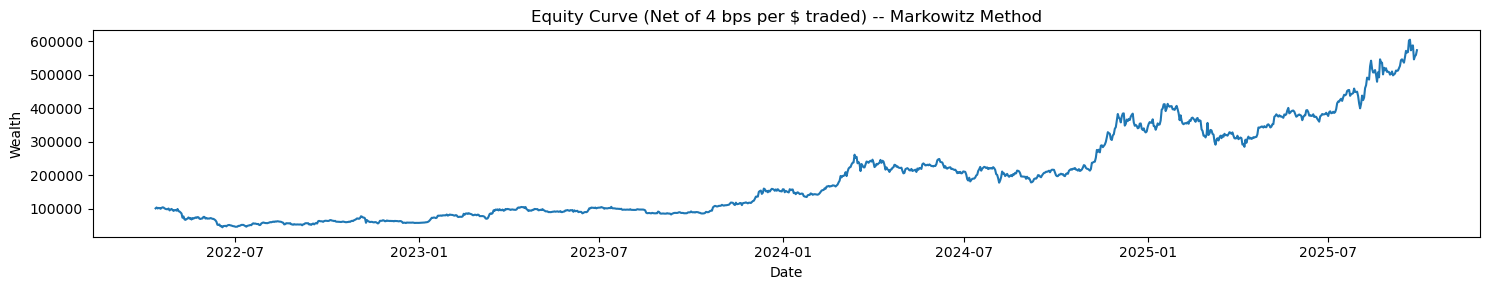

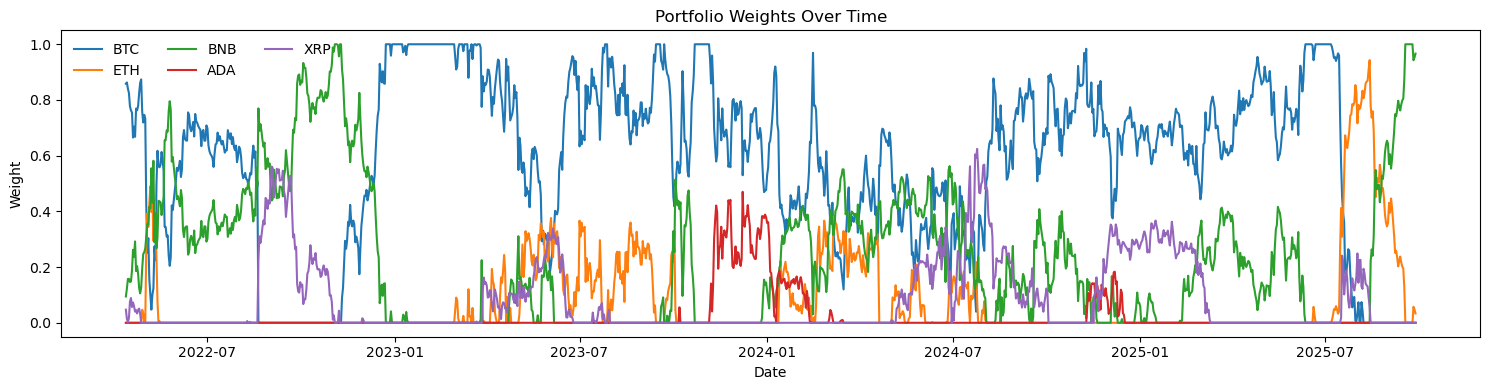

In [26]:
# ---------- Compute rolling weights & net equity ----------
window = 100
lam = 10.0
long_only = True
w_ts = rolling_markowitz_from_log_returns(log_returns, window=window, lam=lam, long_only=long_only)

# Convert to simple returns and align
simple_rets = np.exp(log_returns) - 1.0
simple_rets = simple_rets.loc[w_ts.index]

net = simulate_net_wealth(simple_rets, w_ts, cost_bps=0.0004, X0=100_000.0)

# ---------- Plot 1: Equity curve ----------
plt.figure(figsize=(15,3))
plt.plot(net.index, net["Wealth"].values)
title = "Equity Curve (Net of 4 bps per $ traded) -- Markowitz Method"
if need_demo:
    title += " — demo data"
plt.title(title)
plt.xlabel("Date")
plt.ylabel("Wealth")
plt.tight_layout()
plt.show()

# ---------- Plot 2: Weights through time ----------
plt.figure(figsize=(15,4))
for col in w_ts.columns:
    plt.plot(w_ts.index, w_ts[col].values, label=col)
plt.title("Portfolio Weights Over Time")
plt.xlabel("Date")
plt.ylabel("Weight")
plt.legend(loc="best", ncol=3, frameon=False)
plt.tight_layout()
plt.show()

### Dynamic Portfolio Optimization using Linear–Quadratic Control (LQR):

#### shrinkCov(X, shrink=0.05) :
- Estimate a stable covariance matrix for portfolio optimization.
- When returns $X \in \mathbb{R}^{T\times n}$ are noisy (few time samples, many assets), the raw sample covariance can be unstable or singular.
- To fix that, shrinkage blends $S$ with an identity matrix scaled by the average variance:

    - $\Sigma_{\text{shrunk}} = (1-\gamma)S + \gamma \bar{\sigma}^2 I$
    - where $\bar{\sigma}^2 = \frac{1}{n}\operatorname{tr}(S)$, and $\gamma \in [0,1]$ is your shrinkage intensity (here, 0.05).

In [30]:
def shrink_cov(X, shrink=0.05):
    S = np.cov(X.T, bias=False)
    avg_var = np.trace(S)/S.shape[0]
    return (1-shrink)*S + shrink*avg_var*np.eye(S.shape[0])

####  Ensures $w_i \ge 0$ and $1^\top w = 1$

In [31]:
def project_to_simplex(v):
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u*np.arange(1, len(v)+1) > (cssv - 1))[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1.0)
    return np.maximum(v - theta, 0.0)

#### Estimate_mu_Sigma_from_log(R_log_win)

In [32]:
def estimate_mu_Sigma_from_log(R_log_win: pd.DataFrame):
    mu = R_log_win.mean().values
    Sigma = R_log_win.cov().values
    return mu, Sigma

#### Lagrange-multiplier

In [33]:
def markowitz_target(mu, Sigma, lam=10.0):
    invS = np.linalg.pinv(Sigma)
    ones = np.ones_like(mu)
    a = ones @ invS @ mu
    b = ones @ invS @ ones
    nu = (a - lam) / b
    w = (1.0/lam) * (invS @ (mu - nu*ones))
    s = w.sum()
    if s != 0:
        w = w / s
    return w

### The LQR system : Solving the Bellman optimality recursion in matrix form.

#### The Dynamic Programming Problem :
- In LQR (Linear–Quadratic Regulator), we want to find the control sequence $u_t$ that minimizes the expected cumulative cost:

    $ J = \sum_{t=0}^{\infty} (x_t^\top Q x_t + u_t^\top R u_t) $ subject to the linear dynamics: $x_{t+1} = A x_t + B u_t$

- Here:
	- $x_t$ : state (e.g., portfolio deviation from target weights)
	- $u_t$ : control (trading adjustments)
	- $Q$ : penalty on risk/deviation
	- $R$ : penalty on control effort (transaction cost)
	- $A, B$ : system matrices

#### The Bellman Equation :
- Dynamic programming says:

	$ V(x_t) = \min_{u_t} \big[\, x_t^\top Q x_t + u_t^\top R u_t + V(x_{t+1}) \,\big]$

	- If we assume the value function is quadratic in the state: $V(x_t) = x_t^\top P x_t$,
	- then substituting $x_{t+1} = A x_t + B u_t$ gives:

		$V(x_t) = \min_{u_t}
\left[
x_t^\top Q x_t + u_t^\top R u_t + (A x_t + B u_t)^\top P (A x_t + B u_t)
\right]$

#### Differentiate and find optimal control :
- Take derivative with respect to $u_t$ :

	$\frac{\partial V}{\partial u_t} = 2 R u_t + 2 B^\top P (A x_t + B u_t) = 0$	
	- Simplify :
		$(R + B^\top P B) u_t = - B^\top P A x_t$
	- Thus, the optimal feedback law : 
		$u_t^* = -K x_t, \quad \text{where } K = (R + B^\top P B)^{-1} B^\top P A$

#### Substitute back to find the Riccati equation :
- Plug $u_t^* = -Kx_t$ back into the value function, leading to the recursive equation for $P$ :

	$P = Q + A^\top P A - A^\top P B (R + B^\top P B)^{-1} B^\top P A$
- That’s the discrete algebraic Riccati equation (DARE) — the heart of LQR dynamic programming.

In [36]:
def dare_iter(A, B, Q, R, iters=500, tol=1e-12):
    P = Q.copy()
    for _ in range(iters):
        H = R + B.T @ P @ B
        K = np.linalg.solve(H, B.T @ P @ A) # Optimal feedback gain
        Pn = Q + A.T @ (P - P @ B @ K) @ A
        if np.linalg.norm(Pn - P, ord='fro') < tol:
            P = Pn
            break
        P = Pn
    H = R + B.T @ P @ B
    K = np.linalg.solve(H, B.T @ P @ A)
    return P, K

- tol=1e-12 — Convergence tolerance :

    $ \| P_{k+1} - P_k \|_F < 10^{-12} $ where $\|\cdot\|_F$ is the Frobenius norm (square-root of the sum of squared differences of all entries).

- If the change in $P$ between two iterations is less than $10^{-12}$ , we consider P to have converged to the fixed point $P^*$.

#### Rolling Target Portfolio Construction :
- We estimate a time-varying sequence of optimal portfolios that will serve as the reference path for the LQR controller to track.
- At each time step $t$, we take a rolling window of the most recent $W$ observations of asset log returns:

    $R_{\log,t-W:t-1} =
\begin{bmatrix}
r_{t-W}^\top \\
r_{t-W+1}^\top \\
\vdots \\
r_{t-1}^\top
\end{bmatrix} \in \mathbb{R}^{W \times n}.$

- Markowitz Optimization (Lagrangian Form) :

    The Lagrangian for this problem is:
    
    $\mathcal{L}(w_t, \nu_t) = \mu_t^\top w_t - \frac{\lambda}{2} w_t^\top \Sigma_t w_t - \nu_t(1^\top w_t - 1).$
    
    $ w_t^\star = \frac{1}{\lambda} \Sigma_t^{-1}(\mu_t - \nu_t 1),
\quad
\nu_t = \frac{1^\top \Sigma_t^{-1} \mu_t - \lambda}{1^\top \Sigma_t^{-1} 1}. $

- To ensure a fully-invested and non-negative portfolio:
    $w_t^\star = \arg\min_{w \ge 0, \; 1^\top w = 1} \|w - w_t^\star\|_2^2.$

- Constructing the Rolling Target Series :
    - By sliding the window forward one day at a time, we obtain a time series of optimal static portfolios: $\{ w_W^\star, w_{W+1}^\star, \ldots, w_T^\star \}.$
    - Each $w_t^\star$ reflects the Markowitz-optimal allocation estimated from the most recent $W$ days of data.
    - These targets form the reference trajectory for the dynamic LQR controller, which will optimally trade to track this moving target while balancing turnover costs.

In [47]:
def simulate_lqr_tracking(
    log_returns: pd.DataFrame,
    window=60,
    lam=10.0,
    Q_scale=1.0,
    R_scale=0.05,
    cost_bps=0.004,
    X0=100_000.0,
    long_only=True
):
    R_log = log_returns.dropna()
    dates = R_log.index
    n = R_log.shape[1]

    targets, idxs = [], []
    for t in range(window, len(R_log)):
        R_win = R_log.iloc[t-window:t, :]
        mu, Sigma = estimate_mu_Sigma_from_log(R_win)
        Sigma = shrink_cov(R_win.values, 0.05)
        w_star = markowitz_target(mu, Sigma, lam=lam)
        if long_only:
            w_star = project_to_simplex(w_star)
        targets.append(w_star)
        idxs.append(dates[t])

    w_targets = pd.DataFrame(np.vstack(targets), index=idxs, columns=R_log.columns)
    
    
    A = np.eye(n); B = np.eye(n)
    Q = np.eye(n) * Q_scale
    R = np.eye(n) * R_scale
    P, K = dare_iter(A, B, Q, R)

    simple_rets = (np.exp(R_log) - 1.0).loc[w_targets.index]
    w = np.ones(n) / n
    wealth = [X0]; W = [w.copy()]
    tc_rate_series = []; turnover_series = []

    c = np.full(n, cost_bps) / 1e4

    idx_list = list(w_targets.index)
    for i, date in enumerate(idx_list[:-1]): # Main LQR trading loop
        w_star = w_targets.loc[date].values
        u = -K @ (w - w_star)
        w_next = w + u
        if long_only:
            w_next = project_to_simplex(w_next)
        dw = w_next - w
        tc_rate = float((c * np.abs(dw)).sum())
        r_next = simple_rets.iloc[i+1].values
        X_prev = wealth[-1]
        X_after_tc = X_prev * (1 - tc_rate)
        X_new = X_after_tc * (1 + float(w_next @ r_next))
        wealth.append(X_new)
        W.append(w_next)
        tc_rate_series.append(tc_rate)
        turnover_series.append(float(np.abs(dw).sum()))
        w = w_next
        
    wealth = pd.Series(wealth, index=w_targets.index, name="Wealth")
    weights_df = pd.DataFrame(np.array(W), index=w_targets.index, columns=R_log.columns)
    perf = pd.DataFrame({
        "TC_Rate": tc_rate_series + [np.nan],
        "Turnover": turnover_series + [np.nan],
    }, index=w_targets.index)

    net_ret = wealth.pct_change().dropna()
    ann = (1 + net_ret).prod() ** (365 / len(net_ret)) - 1
    vol = net_ret.std() * np.sqrt(365)
    mdd = (wealth / wealth.cummax() - 1).min()

    summary = pd.DataFrame({
        "Final Wealth": [wealth.iloc[-1]],
        "Ann. Return": [float(ann)],
        "Ann. Vol": [float(vol)],
        "Max Drawdown": [float(mdd)],
        "Mean Daily Turnover": [np.nanmean(turnover_series) if turnover_series else np.nan],
        "Mean Daily TC Rate": [np.nanmean(tc_rate_series) if tc_rate_series else np.nan],
    })
    return w_targets, weights_df, wealth, perf, K, P, summary


#### Define system matrices and penalties :
- We model portfolio weights $w_t$ as a linear system: $w_{t+1} = A w_t + B u_t$, where :
	- $A = I_n$ : current weights persist if no action is taken.
	- $B = I_n$ : actions u_t directly adjust the weights (trades).

- We penalize two things in the LQR cost:

	$J = \sum_t (w_t - w_t^\star)^\top Q (w_t - w_t^\star)u_t^\top R u_t.$
	- $Q$ : penalizes tracking error (deviation from target).
	- $R$ : penalizes transaction effort (trade cost).

- The function dare_iter() solves the discrete algebraic Riccati equation:
	$P = Q + A^\top P A - A^\top P B (R + B^\top P B)^{-1} B^\top P A,$
	- which yields the optimal feedback gain :
	$K = (R + B^\top P B)^{-1} B^\top P A.$
	- This $K$ governs how aggressively we rebalance to correct deviations.

- Initialize :
	- $w_0$ = $\frac{1}{n}\mathbf{1}$ : equal weights.
	- $X_0$ = $100,000$ : initial wealth.
	- $c$ : transaction cost rate vector = 0.4 bps

#### Main LQR trading loop :
- The LQR feedback control : $u_t = -K (w_t - w_t^\star)$ is derived from dynamic programming (Bellman recursion).
- If the portfolio deviates from the Markowitz target, $w_t - w_t^\star$, the controller computes a corrective trade $u_t$.
- Apply rebalancing : $w_{t+1}^{\text{raw}} = w_t + u_t.$
	- Projects $w_{t+1}$ back into the simplex: $\sum_i w_{t+1,i} = 1, \quad w_{t+1,i} \ge 0.$

- Compute total proportional transaction cost: $\text{TC}t = \sum_i c_i | \Delta w{t,i} |.$
-  The wealth dynamics:

	$ \begin{aligned}
X_{t+1} &= X_t (1 - \text{TC}t)(1 + w{t+1}^\top r_{t+1}) \\
&= X_t \Big[ 1 + w_{t+1}^\top r_{t+1} - \text{TC}t(1 + w{t+1}^\top r_{t+1}) \Big].
\end{aligned} $

	- Wealth first decreases due to cost $(1 - \text{TC}_t)$
	- hen grows by the portfolio return $w_{t+1}^\top r_{t+1}$.

- This loop implements the Bellman-optimal trading policy in continuous time :

	$ \min_{\{u_t\}} \sum_t \Big[
(w_t - w_t^\star)^\top Q (w_t - w_t^\star) +
u_t^\top R u_t
\Big],$
- with the dynamic evolution

	$ w_{t+1} = w_t + u_t,
\quad X_{t+1} = X_t(1 - \text{TC}t)(1 + w{t+1}^\top r_{t+1}).$



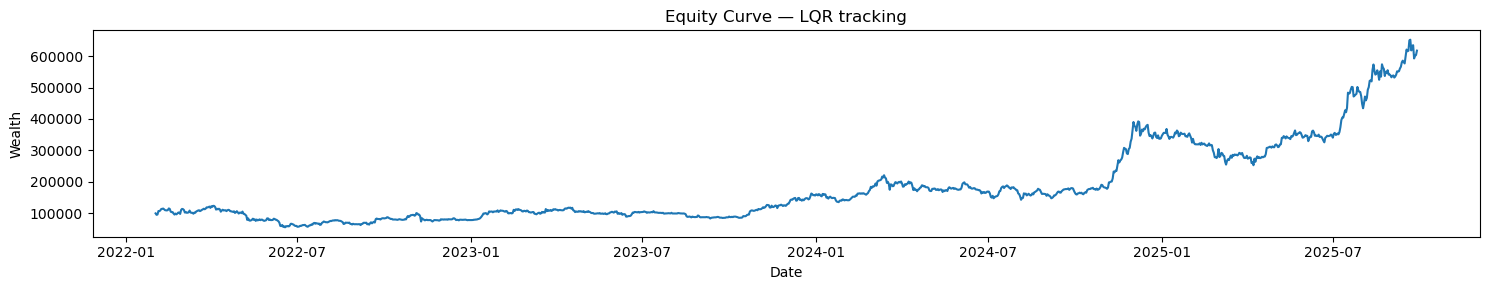

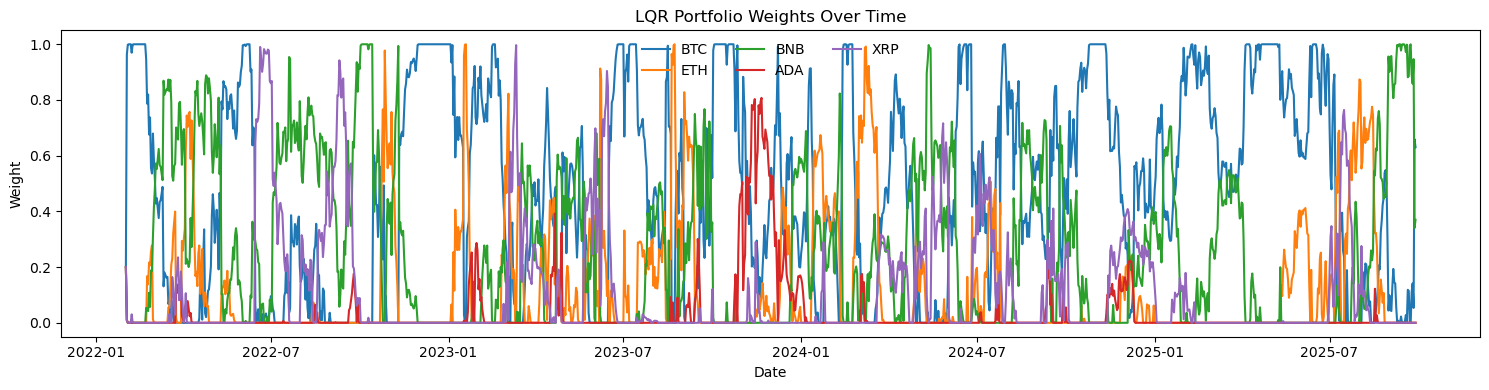

LQR Summary Metrics


,Final Wealth,Ann. Return,Ann. Vol,Max Drawdown,Mean Daily Turnover,Mean Daily TC Rate
0,617250.164496,0.644821,0.552343,-0.551484,0.193731,0.0


In [54]:
w_targets, w_lqr, wealth, perf, K, P, summary = simulate_lqr_tracking(
    log_returns=log_returns,
    window= 30,
    lam= 20.0,
    Q_scale=1.0,
    R_scale=0.05,
    cost_bps=0.004,
    X0=100_000.0,
    long_only=True
)

# Plots
plt.figure(figsize=(15,3))
plt.plot(wealth.index, wealth.values)
ttl = "Equity Curve — LQR tracking"
if need_demo:
    ttl += " — demo data"
plt.title(ttl)
plt.xlabel("Date")
plt.ylabel("Wealth")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,4))
for col in w_lqr.columns:
    plt.plot(w_lqr.index, w_lqr[col].values, label=col)
plt.title("LQR Portfolio Weights Over Time")
plt.xlabel("Date")
plt.ylabel("Weight")
plt.legend(loc="best", ncol=3, frameon=False)
plt.tight_layout()
plt.show()

# ----------- Show summary (notebook-safe) -----------
from IPython.display import display

print("LQR Summary Metrics")
display(summary.round(6))

#### Summary :
Although the LQR-tracking portfolio underperforms the frictionless static Markowitz optimizer in absolute return, it achieves a more realistic and implementable trajectory.
The dynamic policy explicitly internalizes transaction costs and turnover penalties through the R matrix, producing smoother, cost-efficient rebalancing paths.
In essence, Markowitz optimization represents the ideal target under perfect liquidity, while the LQR controller represents the optimal feasible policy under trading frictions and dynamic constraints.